In [ ]:
from datascience import *
import numpy as np
import matplotlib.pyplot as plots
%matplotlib inline
from random import *

# This report covers all calls for police service from 04/16/2022 to 10/12/2022

In [2]:
calls = Table.read_table('Berkeley_PD_-_Calls_for_Service_20260105.csv').sort("EVENTDT")
calls.show(5)

CASENO,OFFENSE,EVENTDT,EVENTTM,CVLEGEND,CVDOW,InDbDate,Block_Location,BLKADDR,City,State
22090464,BURGLARY AUTO,04/16/2022 12:00:00 AM,9:00:00 PM,BURGLARY - VEHICLE,6,10/13/2022 04:42:00 PM,"2000 BLOCK ALLSTON WAY Berkeley CA (37.8691, -122.27008)",2000 BLOCK ALLSTON WAY,Berkeley,CA
22090462,BURGLARY AUTO,04/16/2022 12:00:00 AM,7:00:00 PM,BURGLARY - VEHICLE,6,10/13/2022 04:42:00 PM,"2400 BLOCK DWIGHT WAY Berkeley CA (37.86484, -122.26055)",2400 BLOCK DWIGHT WAY,Berkeley,CA
22017517,DOMESTIC VIOLENCE,04/16/2022 12:00:00 AM,12:00:00 PM,FAMILY OFFENSE,6,10/13/2022 04:42:00 PM,"600 BLOCK ADDISON ST Berkeley CA (37.86575, -122.30193)",600 BLOCK ADDISON ST,Berkeley,CA
22017470,THEFT MISD. (UNDER $950),04/16/2022 12:00:00 AM,1:57:00 PM,LARCENY,6,10/13/2022 04:42:00 PM,"1900 BLOCK STUART ST Berkeley CA (37.85798, -122.27135)",1900 BLOCK STUART ST,Berkeley,CA
22018502,THEFT MISD. (UNDER $950),04/16/2022 12:00:00 AM,12:00:00 PM,LARCENY,6,10/13/2022 04:42:00 PM,"2500 BLOCK GRANT ST Berkeley CA (37.86297, -122.27437)",2500 BLOCK GRANT ST,Berkeley,CA


## What categories of calls are most frequent for police service in Berkeley?

In [ ]:
frequency_description = calls.group("CVLEGEND").sort("count", descending=True)
frequency_description

CVLEGEND,count
LARCENY,1127
BURGLARY - VEHICLE,446
DISORDERLY CONDUCT,437
ASSAULT,344
MOTOR VEHICLE THEFT,332
LARCENY - FROM VEHICLE,294
VANDALISM,264
BURGLARY - RESIDENTIAL,244
FRAUD,209
BURGLARY - COMMERCIAL,174


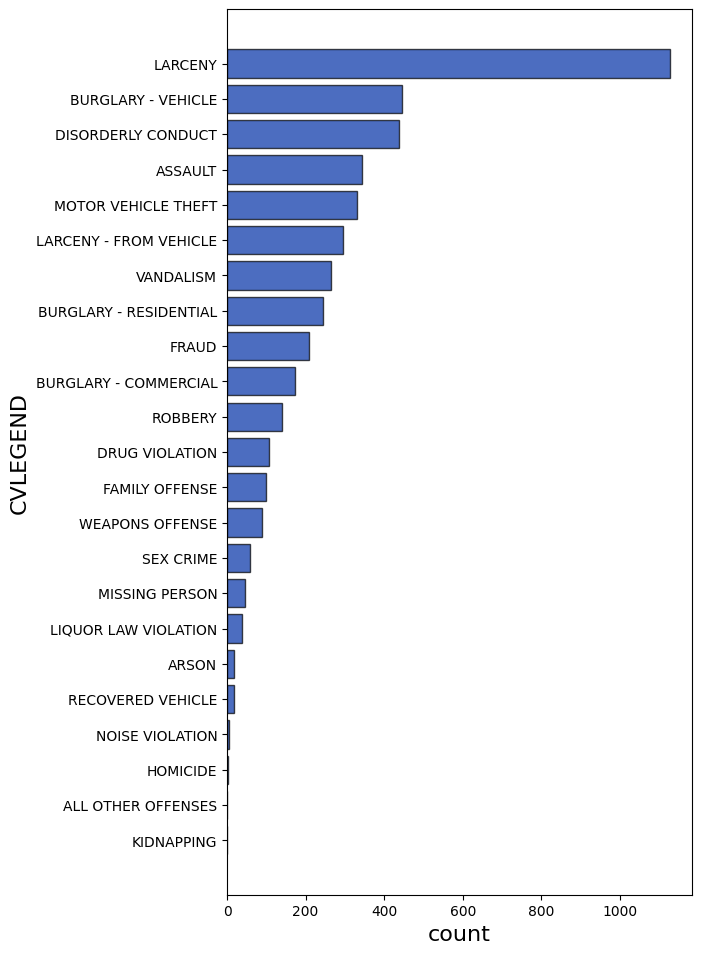

In [ ]:
frequency_description.barh("CVLEGEND","count")

In [81]:
frequency_specific = calls.group("OFFENSE").sort("count", descending=True)
frequency_specific

OFFENSE,count
THEFT MISD. (UNDER $950),660
THEFT FELONY (OVER $950),454
BURGLARY AUTO,446
DISTURBANCE,437
VEHICLE STOLEN,332
THEFT FROM AUTO,294
VANDALISM,264
ASSAULT/BATTERY MISD.,249
BURGLARY RESIDENTIAL,244
BURGLARY COMMERCIAL,174


Theft/larcency is the most common form of crime in Berkeley, with disorderly conduct/disturbance following being a huge gap. With the exception of assault, violent crimes in Berkeley are thankfully not as common as the leading offenses.

# How does police service demand vary by time of day?

In [35]:
time = calls.group("EVENTTM").sort("count", descending=True)
time

EVENTTM,count
12:00:00 AM,142
12:00:00 PM,133
6:00:00 PM,97
8:00:00 AM,91
8:00:00 PM,88
5:00:00 PM,84
9:00:00 PM,82
7:00:00 PM,80
10:00:00 AM,66
10:00:00 PM,66


In [ ]:
#Convert 12-hour time to 24-hour time
def to_24_hour(t):
    hour = int(t.split(":")[0])
    am_pm = t[-2:]

    if am_pm == "AM":
        if hour == 12:
            return 0 
        else:
            return hour
    else:
        if hour == 12:
            return hour 
        else:
            return hour + 12


In [74]:
new_time = time.with_columns("24HRTTM", time.apply(to_24_hour,"EVENTTM"),
                             "count",time.column("count")).select("24HRTTM","count")
new_time.sort("24HRTTM")
#I noticed here that I now have a bunch of unique times that fall within the same hour.
#So I need to group by 24HRTTM now to get the total counts for each hour.
new_time = new_time.group("24HRTTM").sort("count", descending=True)
new_time

24HRTTM,count
15,55
19,52
12,51
13,50
17,50
20,50
0,48
21,48
11,46
14,46


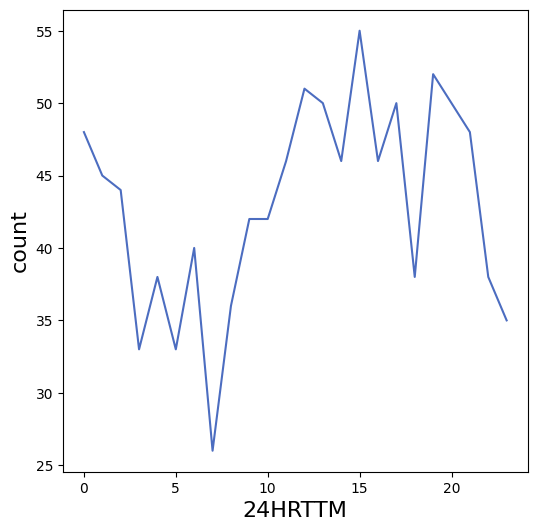

In [70]:
new_time.sort("24HRTTM").plot("24HRTTM","count")

Police service is demanded the most from noon to late evening, with a sharp spike during midnight. 
Police service demand is the lowest in the early morning.

# Does police service demand differ between weekdays and weekends?

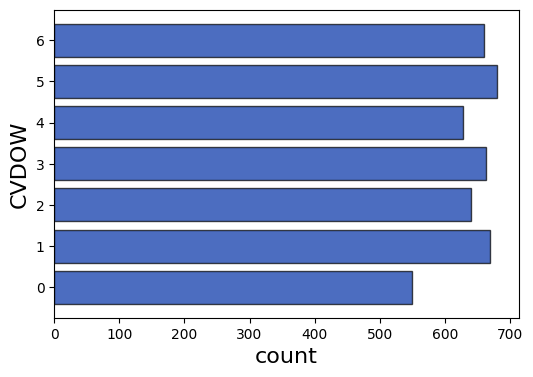

In [93]:
days = calls.group("CVDOW").sort("CVDOW", descending=True)
days.barh("CVDOW","count")

Day of Week Event Occurred: 0 = Sunday 1 = Monday 2 = Tuesday 3 = Wednesday 4 = Thursday 5 = Friday 6 = Saturday

Calls for service are distributed relatively evenly across days of the week, with an exception to Sunday. Contrary to expectations of higher weekend demand, the data does not show an extreme difference between weekdays and weekends over the observed period.

# Are calls for service concentrated in certain areas?

In [96]:
areas = calls.group("BLKADDR").sort("count", descending=True)
areas

BLKADDR,count
2100 BLOCK SHATTUCK AVE,106
1400 BLOCK UNIVERSITY AVE,72
2600 BLOCK TELEGRAPH AVE,69
1000 BLOCK GILMAN ST,68
1300 BLOCK SAN PABLO AVE,43
2400 BLOCK DURANT AVE,37
1400 BLOCK SHATTUCK AVE,35
1900 BLOCK ALLSTON WAY,35
2000 BLOCK ALLSTON WAY,33
2000 BLOCK CENTER ST,33


2100 Block Shattuck Ave is the block with the most police service calls during this time. It's near Downtown Berkeley.

In [115]:
major_corridors = [
    "SHATTUCK AVE",
    "TELEGRAPH AVE",
    "UNIVERSITY AVE",
    "SAN PABLO AVE",
    "GILMAN ST",
    "ALLSTON WAY",
    "CENTER ST"
]

def corridor_label(b):
    for street in major_corridors:
        if street in b:
            return street
    return "OTHER / UNKNOWN"

cord = calls.with_column("Corridor",calls.apply(corridor_label, "BLKADDR"))
cord.group("Corridor").sort("count", descending=True)



Corridor,count
OTHER / UNKNOWN,3065
SHATTUCK AVE,378
UNIVERSITY AVE,282
TELEGRAPH AVE,243
SAN PABLO AVE,197
ALLSTON WAY,138
GILMAN ST,107
CENTER ST,80


A substantial share of calls are associated with major commercial corridors, or areas near UC Berkeley, while a large portion of records lack specific block information and are grouped as Other/Unknown

# Predict a week’s total calls for service based on weekly demand in this database.
This database has been discontinued after 10/22/2022, so I can approximate the accuracy. 

In [ ]:
def to_date(s):
    #Converts it into year month day format so it's easier to work with
    parts = s.split(" ")[0].split("/")  # ['04','16','2022']
    month, day, year = parts
    return np.datetime64(f"{year}-{month}-{day}")

weeks = calls.with_column("Date",calls.apply(to_date, "EVENTDT"))
start_date = min(weeks.column("Date"))

def week_index(d):
    #Calculates the week index for a given date by subtracting the start date and dividing by 7 days
    return int((d - start_date) // np.timedelta64(7, "D")) #This means // 7 days

weeks = weeks.with_column("WeekIndex",calls.apply(week_index, "Date"))
weekly_calls = weeks.group("WeekIndex").sort("WeekIndex")
weekly_calls

WeekIndex,count
0,173
1,166
2,164
3,162
4,166
5,141
6,137
7,167
8,173
9,149


Now I'll perform short-term demand forecasting via linear regression.
Yₜ = calls in week t, Xₜ = calls in week t−1



In [149]:
weekly_counts = weekly_calls.column("count")

def get_vars(i):
    X = weekly_counts[:-i]
    Y = weekly_counts[i:]
    r = float(np.corrcoef(X, Y)[0, 1])
    slope = np.cov(X, Y, bias=True)[0,1] / np.var(X)
    intercept = np.mean(Y) - slope * np.mean(X)
    return r, slope, intercept

i = 1
r, slope, intercept = get_vars(i)
anticipated_calls = intercept + slope * weekly_counts[-i]

print(f"r: {r:.3f}")
print(f"Slope: {slope:.3f}")
print(f"Anticipated calls next week: {anticipated_calls:.0f}")


r: 0.451
Slope: 0.575
Anticipated calls next week: 116


In [150]:
i = 2
r, slope, intercept = get_vars(i)
anticipated_calls = intercept + slope * weekly_counts[-i]

print(f"r: {r:.3f}")
print(f"Slope: {slope:.3f}")
print(f"Anticipated calls next week: {anticipated_calls:.0f}")

r: 0.217
Slope: 0.278
Anticipated calls next week: 177


In [154]:
i = 3
r, slope, intercept = get_vars(i)
anticipated_calls = intercept + slope * weekly_counts[-i]

print(f"r: {r:.3f}")
print(f"Slope: {slope:.3f}")
print(f"Anticipated calls next week: {anticipated_calls:.0f}")

r: 0.202
Slope: 0.267
Anticipated calls next week: 182


The correlation keeps decreasing the further we are from i=1. i is how many weeks back we're looking at to predict how many calls we'd get the very next week. And it's predicted that there will be 177 calls next week after 10/12/2022.